<font size="6">Прогнозирование оттока клиентов телеком компании</font>

## Опиcание проекта

**О компании:**  Заказчик - оператор связи, предоставляет услуги стационарной телефонной связи, подключение к иентренету, сопутствующие услуги (антивирус, выделенная линия технической поддержки, облачное хранилище файлов, стриминговое телевидение).
<br>
<br> **Цель проекта:** создать модель, которая сможет определять клиентов, которые могут отказаться от услуг компании. Модель будет использоваться для  удержания таких клиентов в дальнейшем, способы удержания, например,  промокоды или специальные условия. 
<br>
<br> **Исходные данные:** персональные данные клиентов актуальные на 01.02.2020, информация о подключенных услугах, условия оплаты.
<br>
<br> **Требование к модели:**  Метрика AUC_ROC на тестовых данных должна иметь значение не менее 0.85.

## План


1. Импорт библиотек.
2. Первичное знакомство с данными:
- Импорт данных; 
- Изучение 4-х таблиц по отдельности (методы describe, info, sample);
3. Предобработка:
-  Объединение таблиц при помощи merge по customer_id; 
-  Создание новых столбцов:
    - целевой признак (клиент ушел или нет);
    - как долго является клиентом в днях (до даты окончаняи или до 01.02.2020);
- Обработка пропусков, аномалий и дубликатов;
- Изменение формата данных, где требуется;
- Удаление избыточных столбцов:
    - begin_date;
    - end_date;
    - customer_id;
4. Исследовательский анализ данных:
- Постороение графиков в разрезе оттока;
- Проверка данных на мультиколлинеарность.
5. Разделение данных на выборки (0.25 test).
6. Кодирование OHE.
7. Подбор гиперпараметров при помощи GridSearch у следующих моделей:
- RandomForestClassifier;
- LogisticRegression;
- CatBoostClassifier.
8. Выбор лучшей модели.
9. Тестирование:
- Проверка качества лучшей модели на тестовой выборке (показатель успешности AUC_ROC >= 0.85).
- Исследование важности признаков лучшей модели;
- ROC-кривая;
- Матрица ошибок.

## Первичное знакомство с данными

### Импорт библиотек

Установим библиотеку для постоения матрицы корреляции категоральных и числовых признаков.

In [1]:
pip install phik

     |████████████████████████████████| 679 kB 2.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 48 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik

# импортируем  необходимые функции
from catboost import CatBoostClassifier
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, roc_curve, roc_auc_score, 
                             accuracy_score, precision_score, 
                             recall_score, confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from phik.report import plot_correlation_matrix
from phik import report

# отключим некритические предупреждения в коде
import warnings
warnings.filterwarnings("ignore")

# сбросим ограничение на количество выводимых столбцов, что бы просмотреть все столбцы
pd.set_option('display.max_columns', None)

#зададим константу 
RANDOM_STATE = 130323

Создадим функцию для записи данных в DataFrame и вывода основной информации (пример строк, формат данных, мин., макс. и среднее значение числовых параметров).

In [5]:
# cчтение файла с данными и сохранение в DataFrame
def research_df(path):
    local_path = 'final_datasets/' + path + '.csv'
    server_path = '---' + path + '.csv'
    #импортируем данные
    try:
        df = pd.read_csv(local_path)
    except:
        df = pd.read_csv(server_path)
    
    # приведем столбцы к нижнему регистру
    df.columns = map(str.lower, df.columns)
    
    print('Пример строк')
    display(df.sample(10))
    print('----'*10)
    print(df.info())
    print('----'*10)
    print(df.describe(include='all'))
    return df

###  Информация о договоре

In [6]:
contract_df = research_df('contract')

Пример строк


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
5314,2535-PBCGC,2014-04-01,No,Two year,No,Bank transfer (automatic),64.55,4504.9
4213,3683-QKIUE,2019-06-01,2019-12-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),50.80,288.05
5744,1371-WEPDS,2016-10-01,No,One year,No,Electronic check,55.80,2283.3
4378,6980-CDGFC,2014-07-01,No,One year,Yes,Bank transfer (automatic),20.85,1327.4
6740,7957-RYHQD,2016-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Credit card (automatic),79.20,3233.85
3524,4706-AXVKM,2019-01-01,2019-12-01 00:00:00,Month-to-month,Yes,Credit card (automatic),84.80,906.85
6707,2452-MRMZF,2014-02-01,No,Two year,Yes,Credit card (automatic),25.70,1937.4
5830,6754-WKSHP,2017-08-01,No,One year,No,Bank transfer (automatic),25.35,723.3
5504,6345-ULYRW,2016-02-01,2019-10-01 00:00:00,One year,No,Mailed check,88.40,3912.9
1933,1964-SVLEA,2018-06-01,No,One year,Yes,Mailed check,19.70,415.9


----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
----------------------------------------
        customerid   begindate enddate            type paperlessbilling  \
count         7043        7043    7043            7043             7043   
unique        7043          77       5               3                2   
top     5702-SKUOB  2014-02-01      No  Month-to-month    

Для удобства изменим названия колонок.

In [7]:
contract_df.columns 

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')

In [8]:
contract_df = contract_df.rename(columns = {'customerid' : 'customer_id',
                                            'begindate' : 'begin_date',
                                            'enddate' : 'end_date',
                                            'paperlessbilling' : 'paperless_billing',
                                            'paymentmethod' : 'payment_method',
                                            'monthlycharges' : 'monthly_charges',
                                            'totalcharges' : 'total_charges'})
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


### Персональные данные клиента

Импортируем и изучим данные.

In [9]:
personal_df = research_df('personal')

Пример строк


,customerid,gender,seniorcitizen,partner,dependents
4497,0575-CUQOV,Male,1,Yes,No
6296,4023-RTIQM,Female,1,Yes,No
3239,3890-RTCMS,Male,0,No,No
4578,7766-CLTIC,Female,0,No,No
6024,5095-AESKG,Female,0,Yes,No
3720,1097-FSPVW,Female,0,No,No
1980,1960-UYCNN,Male,0,No,No
6465,8164-OCKUJ,Female,0,Yes,Yes
3749,4424-TKOPW,Male,1,No,No
4233,4664-NJCMS,Female,0,Yes,No


----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
----------------------------------------
        customerid gender  seniorcitizen partner dependents
count         7043   7043    7043.000000    7043       7043
unique        7043      2            NaN       2          2
top     5702-SKUOB   Male            NaN      No         No
freq             1   3555            NaN    3641       4933
mean           NaN    NaN       0.162147     NaN        NaN
std            NaN    NaN       0.368612     NaN        NaN
min            NaN    NaN       0.

In [10]:
personal_df.columns 

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents'], dtype='object')

In [11]:
personal_df = personal_df.rename(columns = {'customerid' : 'customer_id',
                                            'seniorcitizen' : 'senior_citizen'})
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Вывод**
<br>
Таблица `personal` содержит следующие данные:
1. `customer_id` - уникальный идентификатор клиента,  в этой таблице также 7043 записи;       
2. `gender`  - пол клиента;
3. `senior_citizen` - является ли клиент пенсионером;
4. `partner`- наличие партнера;
5. `dependents` - наличие иждивенцев.     

### Информация об интернет-услугах

Импортируем и изучим данные.

In [12]:
internet_df = research_df('internet')

Пример строк


,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
4725,4884-ZTHVF,Fiber optic,No,Yes,No,No,Yes,No
5474,0218-QNVAS,Fiber optic,No,Yes,No,No,Yes,Yes
94,4846-WHAFZ,Fiber optic,No,No,No,No,No,No
4104,8486-AYEQH,Fiber optic,No,No,No,No,No,No
4002,8199-ZLLSA,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
1106,8621-MNIHH,Fiber optic,No,Yes,Yes,No,No,Yes
5017,6034-ZRYCV,DSL,No,Yes,Yes,No,Yes,Yes
4050,6907-FLBER,DSL,No,Yes,No,No,No,No
2848,0512-FLFDW,Fiber optic,No,No,Yes,No,Yes,Yes
5173,6457-USBER,Fiber optic,No,No,No,No,No,Yes


----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
----------------------------------------
        customerid internetservice onlinesecurity onlinebackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     3563-SVYLG     Fiber optic             No           No   
freq             1            3096       

In [13]:
internet_df.columns 

Index(['customerid', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies'],
      dtype='object')

In [14]:
internet_df = internet_df.rename(columns = {'customerid' : 'customer_id',
                                            'internetservice' : 'internet_service',
                                           'onlinesecurity' : 'online_security',
                                           'onlinebackup' : 'online_backup',
                                           'deviceprotection' : 'device_protection',
                                           'techsupport' : 'tech_support',
                                           'streamingtv' : 'streaming_tv',
                                           'streamingmovies' : 'streaming_movies'})
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**Вывод**
<br>
<br>Таблица `internet` содержит данные о подключенных услугах:
<br> `customer_id` - уникальный идентификатор клиента, в этой таблице 5517 записей. Это меньше чем клиентов (7043), в дальнейшем будет считать, что если у клиента нет записи в стаблице `internet`, значит у него не подключены никакие доп.услуги;
<br>
<br>Виды услуг:
- `internet_service` - тип подключения,  может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
- `online_security`  - блокировка небезопасных сайтов;
- `online_backup` - облачное хранилище файлов для резервного копирования данных.
- `device_protection`- антивирус. 
- `tech_support` - выделенная линия технической поддержки.   
- `streaming_tv` - стриминговое телевидение.
- `streaming_movies` - каталог фильмов. 

### Информация об услугах телефонии

Импортируем и изучим данные.

In [15]:
phone_df = research_df('phone')

Пример строк


,customerid,multiplelines
5061,2225-ZRGSG,Yes
973,0655-RBDUG,Yes
1419,0637-YLETY,Yes
5857,4544-RXFMG,No
2839,8679-JOEVF,No
4804,5647-FXOTP,Yes
3410,4415-WNGVR,No
4218,7817-BOQPW,Yes
1039,2460-NGXBJ,Yes
2946,8853-TZDGH,Yes


----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
----------------------------------------
        customerid multiplelines
count         6361          6361
unique        6361             2
top     5702-SKUOB            No
freq             1          3390


In [16]:
phone_df.columns 

Index(['customerid', 'multiplelines'], dtype='object')

In [17]:
phone_df = phone_df.rename(columns = {'customerid' : 'customer_id',
                                            'multiplelines' : 'multiple_lines'})
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Вывод**
<br>
<br>Таблица `phone` содержит данные о наличии у клиента возможности  подключения телефонного аппарата к нескольким линиям одновременно:
- `customer_id` - уникальный идентификатор клиента, в этой таблице 6361 записей. Это меньше чем клиентов (7043), в дальнейшем будет считать, что если у клиента нет записи в стаблице `phone`, значит у него не подключена такая возможность;
- `multiple_lines` - наличие услуги.

## Предобработка

### Объединение таблиц

Объединим таблицы в один датафрейм.

In [18]:
data = contract_df.merge(personal_df, on='customer_id', how='outer') 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 715.3+ KB


In [19]:
data = data.merge(internet_df, on='customer_id', how='outer') 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [20]:
data = data.merge(phone_df, on='customer_id', how='outer') 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [21]:
data.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
556,2654-VBVPB,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),19.90,19.9,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
146,6837-BJYDQ,2019-11-01,No,One year,No,Mailed check,19.60,61.35,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7036,7750-EYXWZ,2019-02-01,No,One year,No,Electronic check,60.65,743.3,Female,0,No,No,DSL,No,Yes,Yes,Yes,Yes,Yes,NaN
5301,2082-OJVTK,2017-07-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,89.20,2698.35,Male,0,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,Yes
5827,3161-GETRM,2017-04-01,No,Month-to-month,Yes,Credit card (automatic),90.05,3097,Male,0,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,Yes


### Обработка пропусков

Избавимся от пропусков, аномалий и дубликатов.

Заполним пропуски значением `No`:

In [22]:
data = data.fillna('No')
data.isna().mean()

customer_id          0.0
begin_date           0.0
end_date             0.0
type                 0.0
paperless_billing    0.0
payment_method       0.0
monthly_charges      0.0
total_charges        0.0
gender               0.0
senior_citizen       0.0
partner              0.0
dependents           0.0
internet_service     0.0
online_security      0.0
online_backup        0.0
device_protection    0.0
tech_support         0.0
streaming_tv         0.0
streaming_movies     0.0
multiple_lines       0.0
dtype: float64

In [23]:
data.duplicated().sum()

0

Явных дубликатов нет.

### Изменение формата данных

Заменим формат в столбцах begin_date и end_date.

In [24]:
data['begin_date'] = pd.to_datetime(data['begin_date'], format='%Y-%m-%d')
data['end_date'] = pd.to_datetime(data[data['end_date'] != 'No']['end_date'], format='%Y-%m-%d %H:%M:%S')
display(data.sample(5))
data.info()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
6312,7055-VKGDA,2015-05-01,2019-11-01,One year,Yes,Credit card (automatic),105.40,5643.4,Male,0,No,No,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,No
4974,4430-UZIPO,2019-09-01,2019-12-01,Month-to-month,Yes,Mailed check,36.85,108.7,Male,0,No,No,DSL,No,Yes,No,Yes,No,No,No
925,5393-HJZSM,2017-06-01,NaT,Month-to-month,No,Bank transfer (automatic),76.30,2404.15,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,No,Yes,No
6624,9888-ZCUMM,2014-10-01,NaT,Two year,Yes,Bank transfer (automatic),60.05,3845.45,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,No
5114,5371-VYLSX,2015-12-01,NaT,Month-to-month,Yes,Electronic check,83.40,4113.7,Female,1,No,No,Fiber optic,Yes,Yes,No,No,No,No,Yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

In [25]:
data.sort_values(by = 'total_charges', ascending=True).head(11)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,No,No,No,No,No,No,No
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,No,No,No,No,No,No,No
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
6754,2775-SEFEE,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),61.90,,Male,0,No,Yes,DSL,Yes,Yes,No,Yes,No,No,Yes
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No


Для клиентов, заключивших договор 01.02.2020, не заполнено значение в total_charges, из-за этого тип данных - object.

Заменим значение на сумму ежемесячного платежа.

In [26]:
data.loc[data['begin_date'] == '2020-02-01', 'total_charges'] = \
                data.loc[data['begin_date'] == '2020-02-01', 'monthly_charges'] 
data['total_charges'] = data['total_charges'].astype('float')
#проверим результат замены
data.loc[data['begin_date'] == '2020-02-01', :]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,20.25,Male,0,No,Yes,No,No,No,No,No,No,No,No
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,80.85,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,25.75,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,56.05,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,19.85,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,25.35,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,20.00,Female,0,Yes,Yes,No,No,No,No,No,No,No,No
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,19.70,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,73.35,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


### Создание новых столбцов

#### Целевой признак

Создадим целевой признак, обозначающий, что клинет ушел. 

In [27]:
data['exited'] = np.nan
data.loc[data['end_date'].isna(), 'exited'] = 0
data['exited'] = data['exited'].fillna(1)
data['exited'] = data['exited'].astype('int')
data.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
4478,0988-JRWWP,2019-11-01,NaT,Month-to-month,Yes,Electronic check,54.20,140.40,Female,0,No,No,DSL,No,No,No,No,Yes,No,No,0
2664,6242-SGYTS,2014-12-01,NaT,One year,Yes,Credit card (automatic),94.95,5791.85,Male,0,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,No,Yes,0
4504,8327-WKMIE,2017-01-01,NaT,One year,No,Credit card (automatic),20.15,785.75,Male,0,No,No,No,No,No,No,No,No,No,No,0
2942,5310-NOOVA,2016-04-01,NaT,Two year,No,Electronic check,19.95,907.05,Male,0,No,No,No,No,No,No,No,No,No,No,0
6984,6447-GORXK,2017-07-01,NaT,Month-to-month,No,Credit card (automatic),25.00,789.20,Male,0,No,Yes,DSL,No,No,No,No,No,No,No,0


#### Срок жизни клиента

Для удобства обучения модели вычислим, как долго человек является клиентом. Для клиентов, для которых известна дата завершеняи договора: вычислим количество месяцев между датой начала и датой заврешения, для остальных вычислим количество месяцев с даты начало по 1 февраля 2020 (это дата актуальности данных). 

Заполним пропуски в колонке end_date значением 2020-02-01

In [28]:
data['end_date'] = data['end_date'].fillna(pd.to_datetime('2020-02-01 00:00:00', format='%Y-%m-%d %H:%M:%S'))
data.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
1349,2625-TRCZQ,2015-11-01,2020-02-01,Month-to-month,Yes,Electronic check,49.65,2553.35,Female,0,Yes,No,DSL,No,Yes,No,No,Yes,Yes,No,0
2857,7771-CFQRQ,2016-03-01,2020-02-01,Two year,No,Bank transfer (automatic),63.80,3007.25,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,No,Yes,No,0
2815,0772-GYEQQ,2019-08-01,2019-11-01,Month-to-month,Yes,Mailed check,88.35,262.05,Male,0,No,No,Fiber optic,No,No,Yes,Yes,Yes,No,No,1
4927,4774-HHGGS,2017-08-01,2020-02-01,Two year,No,Mailed check,19.05,637.55,Male,0,Yes,No,No,No,No,No,No,No,No,No,0
5528,9127-QRZMH,2016-06-01,2020-02-01,One year,Yes,Bank transfer (automatic),59.85,2603.95,Male,0,Yes,No,DSL,Yes,Yes,No,Yes,No,No,No,0


In [29]:
data['delta'] = (data['end_date'] - data['begin_date']).dt.days
data.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,delta
5903,1455-HFBXA,2015-10-01,2020-02-01,Two year,Yes,Credit card (automatic),91.60,4627.80,Male,0,Yes,No,Fiber optic,Yes,No,Yes,Yes,No,No,Yes,0,1584
3694,1150-WFARN,2014-05-01,2019-12-01,Two year,Yes,Credit card (automatic),108.75,7156.20,Female,0,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes,1,2040
4110,5208-FVQKB,2014-04-01,2020-02-01,Two year,No,Mailed check,67.95,4664.15,Male,0,Yes,No,DSL,Yes,Yes,No,Yes,No,Yes,No,0,2132
2262,4529-CKBCL,2019-11-01,2020-01-01,Month-to-month,Yes,Electronic check,80.20,146.05,Female,0,No,No,Fiber optic,No,No,No,No,Yes,No,No,1,61
3365,3865-ZFZIB,2018-07-01,2020-02-01,Two year,No,Mailed check,19.65,358.15,Male,0,No,No,No,No,No,No,No,No,No,No,0,580


### Удаление избыточных столбцов

Для модели будут изыбыточны колонки с датами `begin_date`, `end_date` поэтому удалим их их финального датасета. Уникальный идентификатор пользователя `customer_id` не несет смысловой нагрузки в нашем проекте, его тоже удалим.

In [30]:
data = data.drop(columns =['begin_date','end_date','customer_id'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

## Исследовательский анализ данных

### Постороение графиков в разрезе оттока

Создадим функцию для постороения графиков.

In [31]:
data_for_graph = data
data_for_graph['senior_citizen'] = data_for_graph['senior_citizen'].astype('object')
data_for_graph.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   object 
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

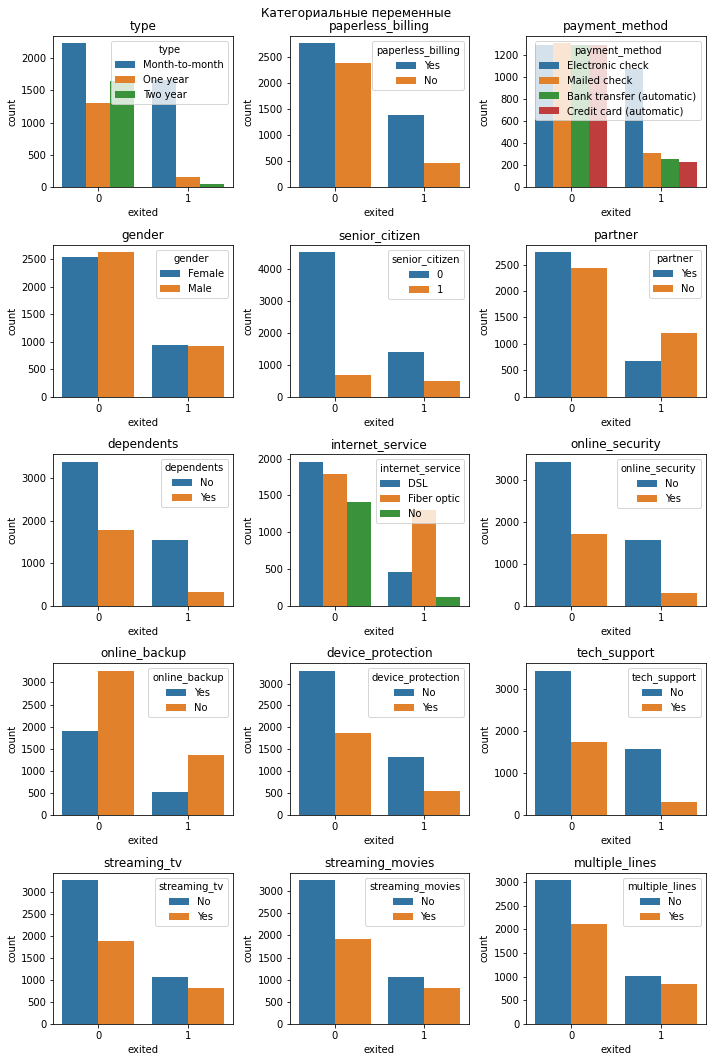

In [32]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(10,15))
fig.suptitle('Категориальные переменные')
axes = axs.ravel()
for  i, column in enumerate(data_for_graph.select_dtypes("object").columns):
    sns.countplot(x='exited', 
                      hue=column, 
                      data=data_for_graph,
                      ax=axes[i])
    axes[i].set_title(column)
plt.tight_layout()
plt.show()

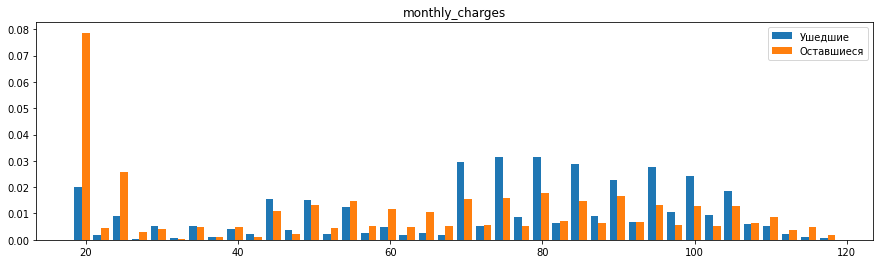

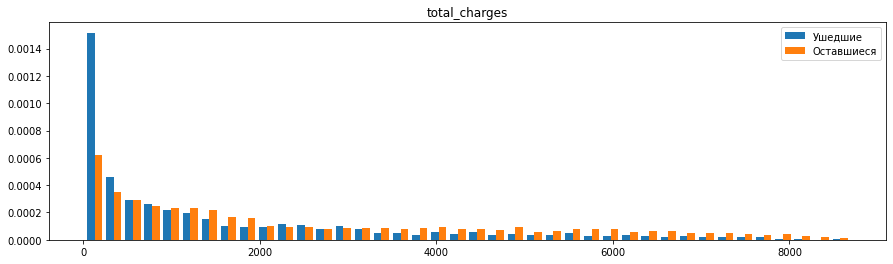

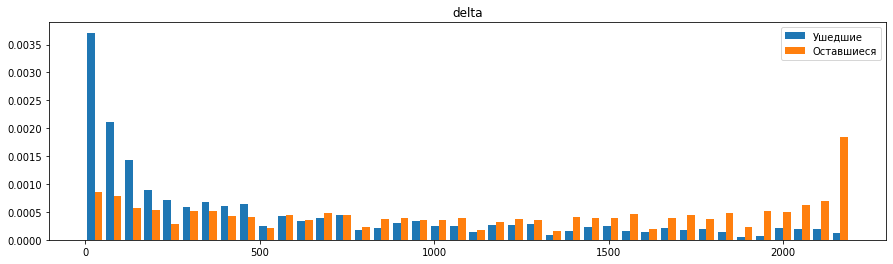

In [33]:
for column in (data_for_graph.drop(['exited'], axis=1).select_dtypes(exclude = "object").columns):
    plt.figure(figsize=(15,4))
    plt.hist([data_for_graph[data_for_graph['exited'] == 1][column], data_for_graph[data_for_graph['exited'] == 0][column]], 
                 label=['Ушедшие', 'Оставшиеся'], 
                 density=True, 
                 bins = 40)
    plt.legend()
    plt.title(column)
    plt.show()

**Вывод** 
<br> Среди ушедших клиентов:
 - большинство использовало ежемесяный тип оплаты;
 - большинство использовало электронные чеки;
 - большинство имело ежемесячный платеж размером 60-100 у.е.;
 - общая оплаченная сумма чаще всего - меньше 1000 у.е.;
 - большинство  использовало оптоволокно;
 - не использовали такие сервисы как антивирус (`device_protection`), блокировка небезопасных сайтов (`online_security`), выделенная линия технической поддержки (`tech_support`);
 - большинство было клиенатми менее 100 дней.


### Проверка данных на мультиколлинеарность

Посторим матрицу корреляции для числовых и категоральных признаков.

In [34]:
phik_overview = data_for_graph.phik_matrix(interval_cols = ['monthly_charges', 'total_charges', 'exited', 'delta'])
phik_overview.round(2)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,delta
type,1.00,0.11,0.28,0.39,0.51,0.00,0.09,0.18,0.15,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.07,0.25,0.66
paperless_billing,0.11,1.00,0.37,0.47,0.21,0.00,0.24,0.01,0.17,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.25,0.30,0.00
payment_method,0.28,0.37,1.00,0.40,0.35,0.00,0.29,0.24,0.22,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.34,0.45,0.38
monthly_charges,0.39,0.47,0.40,1.00,0.76,0.01,0.30,0.20,0.18,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.68,0.36,0.41
total_charges,0.51,0.21,0.35,0.76,1.00,0.00,0.15,0.42,0.11,0.51,0.54,0.66,0.67,0.57,0.66,0.67,0.61,0.28,0.84
gender,0.00,0.00,0.00,0.01,0.00,1.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
senior_citizen,0.09,0.24,0.29,0.30,0.15,0.00,1.00,0.02,0.32,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.22,0.23,0.03
partner,0.18,0.01,0.24,0.20,0.42,0.00,0.02,1.00,0.65,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.22,0.23,0.49
dependents,0.15,0.17,0.22,0.18,0.11,0.00,0.32,0.65,1.00,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.03,0.25,0.21
internet_service,0.51,0.23,0.32,0.92,0.51,0.00,0.16,0.00,0.11,1.00,0.24,0.23,0.23,0.24,0.27,0.27,0.23,0.20,0.02


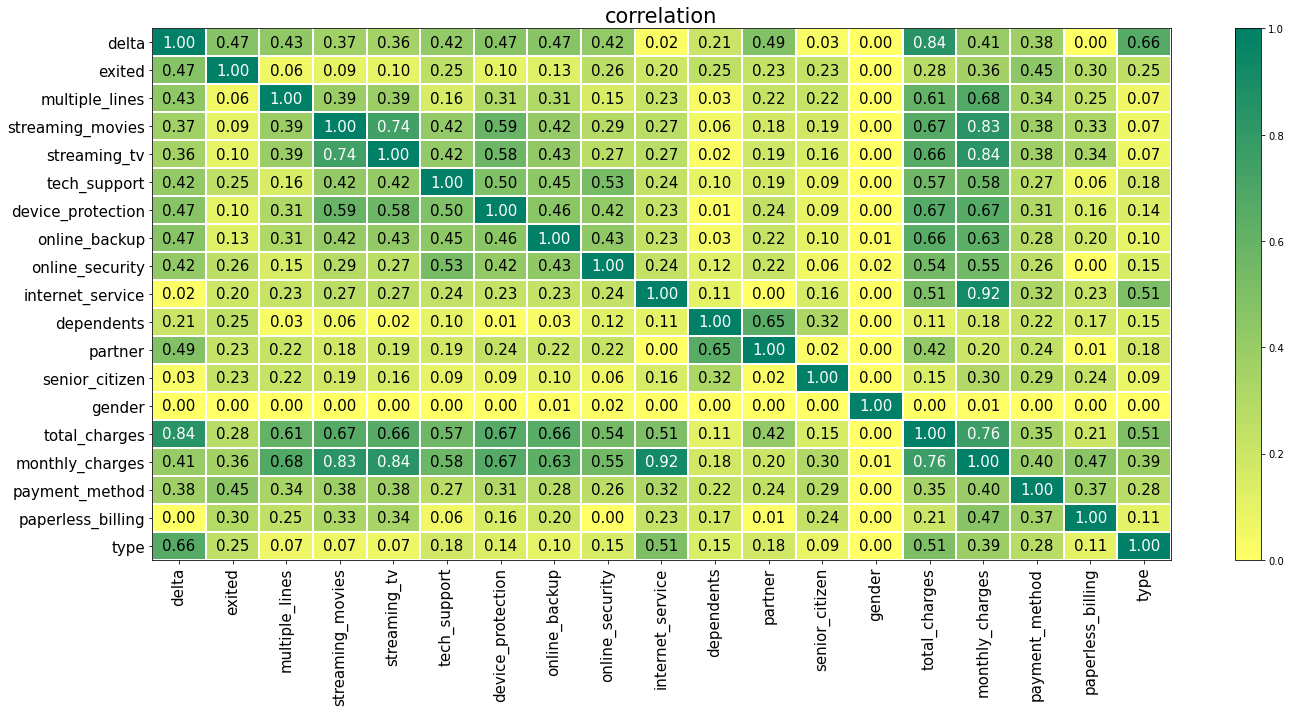

In [35]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="summer_r", 
                        title="correlation", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

<div class='alert alert-success'> 👍
Круто что владеешь такой мощной техникой визуализации как тепловая карта. На ней не всегда видны корреляции между признаками. Колинеарность с помощью данного метода не проверить, тк тут выявляются нелинейные взаимосвязи признаков, для проверки коллинеарности подходит например метод Пирсона 

Высокая корреляция (больше 0,7) наблюдается между признаками  streaming_tv и streaming_movies. В данных для обучения оставим только один признак - streaming_tv.

In [36]:
data = data.drop(columns =['streaming_movies'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   object 
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  multiple_lines     7043 non-null   object 
 16  exited             7043 

<div class='alert alert-success'> 👍
На данном этапе работа принята, продолжай дальше!

## Моделирование

Обучим разные модели:

- RandomForestClassifier (потребуется OHE кодирование категориальных признаков);
- LogisticRegression (потребуется OHE кодирование категориальных признаков);
- CatBoostClassifier.


In [37]:
features = data.drop(['exited'], axis=1)
target = data['exited']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5282, 17)
(1761, 17)
(5282,)
(1761,)


In [38]:
ohe_features = features.select_dtypes("object").columns.to_list()
ohe_features

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'multiple_lines']

In [39]:
num_features = features.select_dtypes(exclude='object').columns.to_list()
num_features

['monthly_charges', 'total_charges', 'delta']

### RandomForestClassifier

In [40]:
%%time

col_transformer_rf = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough'
)

model_rf = RandomForestClassifier(
    random_state=RANDOM_STATE, class_weight='balanced')

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestclassifier__n_estimators': [250], #range(50, 451, 100),
    'randomforestclassifier__max_depth': range(7, 10),
    'randomforestclassifier__min_samples_split': [3], #(3, 4),
    'randomforestclassifier__min_samples_leaf': [1] #(1, 3)
}

gs_rf = GridSearchCV(
    pipline_rf,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=3
)

gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END randomforestclassifier__max_depth=7, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=250;, score=0.860 total time=   0.8s
[CV 2/5] END randomforestclassifier__max_depth=7, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=250;, score=0.859 total time=   0.8s
[CV 3/5] END randomforestclassifier__max_depth=7, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=250;, score=0.865 total time=   0.8s
[CV 4/5] END randomforestclassifier__max_depth=7, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=250;, score=0.851 total time=   0.9s
[CV 5/5] END randomforestclassifier__max_depth=7, randomforestclassifier__min_samples_le

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection...
                                                                          'total_charges',
                                                                          'delta'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=130323))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(7, 10),
                         'randomforestclassifier__min_samples_leaf': [1],
                         'randomforestclassifier__min_samples_split': [3],
                         'randomforestclassifier__n_estimators': [250]},
             scoring='roc_auc', verbose=3)

In [41]:
rf_best_auc_roc = gs_rf.best_score_
print('Параметрв лучшей модели Random Forest: ', gs_rf.best_params_)
print(f"auc_roc для модели Random Forest на кросс валидации: {rf_best_auc_roc:.3f}")

Параметрв лучшей модели Random Forest:  {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 250}
auc_roc для модели Random Forest на кросс валидации: 0.855


### LogisticRegression

In [42]:
%%time

col_transformer_lr= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

model_lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

pipline_lr = make_pipeline(col_transformer_lr, model_lr)

param_grid_lr = {
    'logisticregression__solver': ['lbfgs'], #, 'liblinear'],
    'logisticregression__C': np.arange(0.5, 1.01, 0.1)
}

gs_lr =  GridSearchCV(
    pipline_lr, 
    param_grid=param_grid_lr, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=3
)

gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.852 total time=   1.0s
[CV 2/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.852 total time=   1.0s
[CV 3/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.854 total time=   1.1s
[CV 4/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.836 total time=   0.9s
[CV 5/5] END logisticregression__C=0.5, logisticregression__solver=lbfgs;, score=0.824 total time=   0.7s
[CV 1/5] END logisticregression__C=0.6, logisticregression__solver=lbfgs;, score=0.852 total time=   0.6s
[CV 2/5] END logisticregression__C=0.6, logisticregression__solver=lbfgs;, score=0.852 total time=   0.7s
[CV 3/5] END logisticregression__C=0.6, logisticregression__solver=lbfgs;, score=0.854 total time=   0.9s
[CV 4/5] END logisticregression__C=0.6, logisticregression__solver=lbfgs;, score=0.836 total

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection...
                                                                          'streaming_tv',
                                                                          'multiple_lines']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'delta'])])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=130323))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'logisticregression__solver': ['lbfgs']},
             scoring='roc_auc', verbose=3)

In [43]:
lr_best_auc_roc = gs_lr.best_score_
print('Параметрв лучшей модели Logistic Regression: ', gs_lr.best_params_)
print(f"auc_roc для модели Logistic Regression на кросс валидации: {lr_best_auc_roc:.3f}")

Параметрв лучшей модели Logistic Regression:  {'logisticregression__C': 0.9999999999999999, 'logisticregression__solver': 'lbfgs'}
auc_roc для модели Logistic Regression на кросс валидации: 0.843


### CatBoostClassifier

In [44]:
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

In [45]:
X_train_cb[ohe_features] = X_train_cb[ohe_features].astype('category')
X_test_cb[ohe_features] = X_test_cb[ohe_features].astype('category')

display(X_train_cb.info())
display(X_test_cb.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1535 to 1086
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5282 non-null   category
 1   paperless_billing  5282 non-null   category
 2   payment_method     5282 non-null   category
 3   monthly_charges    5282 non-null   float64 
 4   total_charges      5282 non-null   float64 
 5   gender             5282 non-null   category
 6   senior_citizen     5282 non-null   category
 7   partner            5282 non-null   category
 8   dependents         5282 non-null   category
 9   internet_service   5282 non-null   category
 10  online_security    5282 non-null   category
 11  online_backup      5282 non-null   category
 12  device_protection  5282 non-null   category
 13  tech_support       5282 non-null   category
 14  streaming_tv       5282 non-null   category
 15  multiple_lines     5282 non-null   category
 16  del

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761 entries, 6345 to 2953
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               1761 non-null   category
 1   paperless_billing  1761 non-null   category
 2   payment_method     1761 non-null   category
 3   monthly_charges    1761 non-null   float64 
 4   total_charges      1761 non-null   float64 
 5   gender             1761 non-null   category
 6   senior_citizen     1761 non-null   category
 7   partner            1761 non-null   category
 8   dependents         1761 non-null   category
 9   internet_service   1761 non-null   category
 10  online_security    1761 non-null   category
 11  online_backup      1761 non-null   category
 12  device_protection  1761 non-null   category
 13  tech_support       1761 non-null   category
 14  streaming_tv       1761 non-null   category
 15  multiple_lines     1761 non-null   category
 16  del

None

In [46]:
%%time

model_cb = CatBoostClassifier(random_state=RANDOM_STATE, 
                              auto_class_weights='Balanced',
                              cat_features=ohe_features)

param_grid_cb = {
    'max_depth': range(3,5), #range(3,9),
    'learning_rate': [0.1], #[0.005, 0.01, 0.1],
    'n_estimators': range(500, 901, 100)
}

gs_cb =  GridSearchCV(
    model_cb, 
    param_grid=param_grid_cb, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=3
)

gs_cb.fit(X_train_cb, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6612803	total: 50.5ms	remaining: 25.2s
1:	learn: 0.6329505	total: 54.1ms	remaining: 13.5s
2:	learn: 0.6125737	total: 58.1ms	remaining: 9.63s
3:	learn: 0.5934059	total: 61.9ms	remaining: 7.68s
4:	learn: 0.5795340	total: 65.1ms	remaining: 6.44s
5:	learn: 0.5685935	total: 68.5ms	remaining: 5.64s
6:	learn: 0.5574771	total: 72ms	remaining: 5.07s
7:	learn: 0.5481863	total: 75.6ms	remaining: 4.65s
8:	learn: 0.5368609	total: 79.7ms	remaining: 4.35s
9:	learn: 0.5322848	total: 83.7ms	remaining: 4.1s
10:	learn: 0.5267469	total: 87.3ms	remaining: 3.88s
11:	learn: 0.5216868	total: 90.3ms	remaining: 3.67s
12:	learn: 0.5153274	total: 93.5ms	remaining: 3.5s
13:	learn: 0.5083216	total: 96.6ms	remaining: 3.35s
14:	learn: 0.5057055	total: 100ms	remaining: 3.23s
15:	learn: 0.5026607	total: 103ms	remaining: 3.12s
16:	learn: 0.5006154	total: 107ms	remaining: 3.03s
17:	learn: 0.4986509	total: 109ms	remaining: 2.92s
18:	learn: 0.4969719	

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fbf269aa670>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': range(3, 5),
                         'n_estimators': range(500, 901, 100)},
             scoring='roc_auc', verbose=3)

In [47]:
cb_best_auc_roc = gs_cb.best_score_
print('Параметрв лучшей модели CatBoostClassifier: ', gs_cb.best_params_)
print(f"auc_roc для модели CatBoostClassifier на кросс валидации: {cb_best_auc_roc:.3f}")

Параметрв лучшей модели CatBoostClassifier:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 900}
auc_roc для модели CatBoostClassifier на кросс валидации: 0.910


### Сравнение моделей

In [48]:
result = pd.DataFrame(
     [rf_best_auc_roc, lr_best_auc_roc, cb_best_auc_roc], 
    index=['RandomForestClassifier', 'LogisticRegression', 'CatBoostCLassifier'], 
    columns=['AUC_ROC']
)
result

,AUC_ROC
RandomForestClassifier,0.85523
LogisticRegression,0.84347
CatBoostCLassifier,0.90967


На обучающей выборке наибольшее значение AUC_ROC у модели CatBoostCLassifier.

Далее протестируем эту модель на тестовой выборке.

## Тестирование лучшей модели

### Метрики лучшей модели на тестовой выборке

In [49]:
#создадим таблицу для записи результатов лучшей модели на тесте
model_results = {}

best_model = gs_cb
y_pred = best_model.predict(X_test_cb)

model_results['AUC-ROC'] = roc_auc_score(y_test, best_model.predict_proba(X_test_cb)[:,1])
model_results['precision'] = precision_score(y_test, y_pred)
model_results['recall'] = recall_score(y_test, y_pred)
model_results['accuracy'] = accuracy_score(y_test, y_pred)
model_results

{'AUC-ROC': 0.927511892701766,
 'precision': 0.6947935368043088,
 'recall': 0.8164556962025317,
 'accuracy': 0.8540601930721181}

На тестовой выборке значение `AUC-ROC` = 0.927, что удовлетворяет условиям проекта (>0.85). Задача проекта выполненаю

### ROC-кривая

Выведем ROC-кривую лучшей модели.

AUC-ROC CatBoostClassifier 0.927511892701766


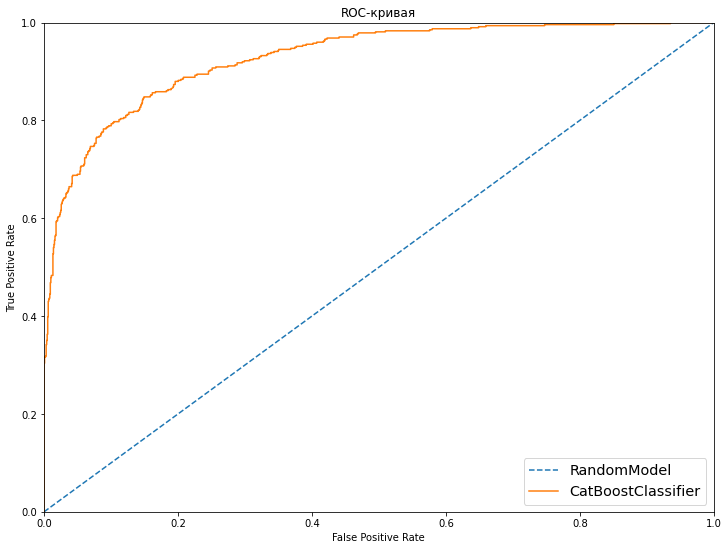

In [50]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


probabilities_test = best_model.predict_proba(X_test_cb)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

print('AUC-ROC CatBoostClassifier', model_results['AUC-ROC'])
plt.plot(fpr, tpr, label='CatBoostClassifier')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

### Матрица ошибок

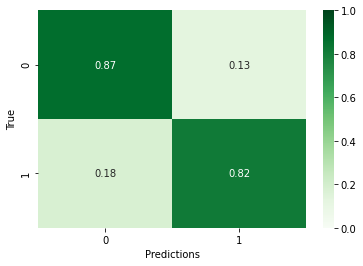

In [51]:
#создадим матрицу ошибок

cfm = {}
cfm = confusion_matrix(y_test, y_pred, normalize='true')

sns.heatmap(pd.DataFrame(cfm), 
            annot=True, 
            cmap='Greens', 
            vmin=0, 
            vmax=1)
plt.xlabel('Predictions')
plt.ylabel('True')
plt.show()

Выбанная модель CatBoostClassifier хорошо предсказывает отрицательный класс (факт того, что клиент остался). Истинно отрицательные ответы - 0.87.

Чуть хуже предсказывает уход клиента (истинно положительные предсказания = 0.82).

### Исследование важности признаков

In [52]:
feat_import = pd.DataFrame(data = {'feature': X_train.columns, 
                                   'percent': best_model.best_estimator_.feature_importances_})
feat_import.sort_values('percent', ascending=False).reset_index(drop=True)

,feature,percent
0,delta,54.561454
1,total_charges,10.718540
2,monthly_charges,10.034917
3,type,9.631931
4,internet_service,3.657171
5,payment_method,3.057264
6,gender,1.149792
7,dependents,1.035505
8,tech_support,1.006549
9,paperless_billing,0.934128


**Вывод**
<br> Наибольший вклад вносят признаки:
- `delta` - количество дней, сколько клиент пользуется услугами компании;
- `total_charges` - общая потраченная клиентом сумма;
- `monthly_charges` - сумма ежемесячного платежа;
- `type` - тип оплаты услуг по договору (ежемесячно, раз в год, раз в два года);
- `internet_service` - тип интернета(dsl или оптоволокно).


## Вывод

В ходе роботы был выполнен:
<br>
1. Первичное знакомство с данными.
2. Предобработка, в которой мы объединили 4 датасета в один, создали дополнительные признаки, заполнили пропуски.
3. Исследовательских анализ данных, в котором построили графики в разрезе оттока и тепловую карту с взаимосвязями признаков. В ходе ИАД замечено, что:
- ушедшие клиенты плтили в месяц больше, оставшихся (60-100 у.е. против 20 у.е.)
- большинство использовало ежемесяный тип оплаты;
- большинство использовало электронные чеки;
- не использовали такие сервисы как антивирус (`device_protection`), блокировка небезопасных сайтов (`online_security`), выделенная линия технической поддержки (`tech_support`);
- большинство было клиенатми менее 100 дней.
4. Моделирование. При помощи кросс-валидации были были обучены 3 модели RandomForestClassifier, LogisticRegression, CatBosstClassifier. 
5. В результате обучения лучше всех себя показала модель CatBosstClassifier, на тестовых данных метрика ROC_AUC = 0.926.

## Отчет

<font size="6">Модель для предсказания оттока клиентов оператора связи</font>

### Цели проекта

**О компании:**  «Ниединогоразрыва.ком» - оператор связи, предоставляет услуги стационарной телефонной связи, подключение к иентренету, сопутствующие услуги (антивирус, выделенная линия технической поддержки, облачное хранилище файлов, стриминговое телевидение).

**Цель проекта:** создать модель, которая сможет определять клиентов, которые могут отказаться от услуг компании. Модель будет использоваться для  удержания таких клиентов в дальнейшем, способы удержания, например,  промокоды или специальные условия.

**Исходные данные:** персональные данные клиентов актуальные на 01.02.2020, информация о подключенных услугах, условия оплаты. Исходные данные содержатся в  4 датасетах:

1. информация о договоре;
2. персональные данные клиентов;
3. данные о подключенных интернет услугах;
4. данные о услугах телефонии.

**Требование к модели:**  В качестве метрики выбрана AUC-ROC. На тестовых данных должно получиться значение не меньше 0.85. Эта метрика подходит для оценки качества модели, т.к. перед нами стоит задача бинарной классификации: уйдет клиент (1), или останется(0). Площадь под ROC-кривой покажет способность модели различать классы.

### Ход проекта

Проект был выполнен полностью в соответствии с исходным планом работ.

Ключевые шаги проекта: 

1. Знакомство с данными.
2. После знакомства с данными, мы провели предобработку:
    1. Объединили 4 датасета по уникальному идентификатору клиента.
    2. Пропуски, получившиеся при объединении, заполнили значением `No.`
    3. Для клиентов с датой заключения договора 01-02-2020 заполнили общую сумму трат клиента значением их ежемесячного платежа.
    4. На основании даты расторжения договора создали целевой признак `exited`: 1 - клиент ушел, 0 - действующий клиент.
    5. Даты заключения и расторжения договора не удобно использовать для обучения модели, заменили их разностью в днях.
3. Проверили исследование данных в разрезе оттока, для каждого признака построили отдельный график. В ходе ИАД выявлены следующие инсайты, которые можно учесть при планировании акций по удержанию клиентов::
    1. ушедшие клиенты платили в месяц больше, оставшихся (60-100 у.е. против 20 у.е.);
    2. среди ушедших клиентов большинство использовало ежемесячный тип оплаты;
    3. среди ушедших клиентов большинство использовало электронные чеки;
    4. ушедшие клиенты не использовали такие сервисы как антивирус, блокировка небезопасных сайтов , выделенная линия технической поддержки;
    5. большинство бывших клиентов ушло в течении первых 100 дней.
4. Проверили исследование взаимосвязи признаков. Обнаружили зависимость между наличием у клиента услуги стримингового телевиденья и доступа к каталогу фильмов.
    
    Из набора признаков для обучения модели исключили:
    
    1. уникальный идентификатор клиента;
    2. дату заключения договора;
    3. дата расторжения договора;
    4. наличие доступа к каталогу фильмов.
    1. Набор признаков для обучения:
        1. Категоральные:
            - `type`,
            - `paperless_billing`,
            - `payment_method`,
            - `gender`,
            - `senior_citizen`,
            - `partner`,
            - `dependents`,
            - `internet_service`,
            - `online_security`,
            - `online_backup`,
            - `device_protection`,
            - `tech_support`,
            - `streaming_tv`,
            - `multiple_lines`
        2. Численные:
            - `monthly_charges,`
            - `total_charges,`
            - `delta`
5. Обучили три модели. В исходных данных наблюдается дисбаланс (25% целевого признака = 1), поэтому при обучении всех моделей использовали 
    1. Случайный лес. Для данной модели категориальные признаки закодировали при помощи OneHotEncoder, численные признаки стандартизировали при помощи StandardScaler. При подборе гиперпараметров использовали GridSearchCV. 
    2. Логистическая регрессия. Для данной модели категориальные признаки закодировали при помощи OneHotEncoder, численные признаки стандартизировали при помощи StandardScaler. При подборе гиперпараметров использовали GridSearchCV.
    3. CatBoostClassifier. Для данной модели категориальным признакам поменяли тип данных с object на category. При подборе гиперпараметров использовали GridSearchCV.
6. Лучший показатель AUC-ROC на обучающей выборке имеет CatBoostClassifier. Модель имеет следующие гиперапраметры:
    1. `learning_rate`: 0.1,` 
    2. `max_depth`: 4,` 
    3. `n_estimators`: 900`
7. При проверке качества модели на тестовых данных (25% от исходного датасета) выбранная модель имеет AUC-ROC  = 0,927, что больше установленного заказчиком (0.85).
| AUC-ROC | precision | recall |accuracy |
|----------|----------|----------|----------|
| 0.927   | 0.694   | 0.816   | 0.854   |